<a href="https://colab.research.google.com/github/ujwalreddy18/Twitter-spam-detection/blob/main/Twitter-spam-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============ CELL 1: Imports ============
import re, json, math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report,
    precision_recall_fscore_support,
    accuracy_score,
    confusion_matrix,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
)
from joblib import dump, load

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertModel, BertForSequenceClassification, get_linear_schedule_with_warmup

pd.set_option("display.max_colwidth", 160)
pd.set_option("display.width", 160)

print("✅ Imports ready")

✅ Imports ready


In [ ]:
# ============ CELL 2: Load dataset (ONLY this file) ============
df = pd.read_csv("/content/spam (1).csv", encoding="latin-1", engine="python", on_bad_lines="skip")

# Expect classic SMS spam columns: v1=label ('ham'/'spam'), v2=text
if not set(["v1","v2"]).issubset(df.columns):
    raise ValueError(f"Expected columns 'v1' (label) and 'v2' (text). Found: {list(df.columns)}")

df = df[["v1","v2"]].rename(columns={"v1":"label","v2":"text"}).dropna()
df["text"] = df["text"].astype(str)

print("Rows:", len(df))
df.head()


Rows: 5572


,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [ ]:
# ============ CELL 3: Cleaning & helpers ============
URL = re.compile(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+\.[a-z]{2,4}/)[^\s]*)")
USER = re.compile(r"@\w+")
HASH = re.compile(r"#\w+")
NUM  = re.compile(r"\d+([.,:/-]\d+)*")
WS   = re.compile(r"\s+")
REPEAT = re.compile(r"(.)\1{2,}")  # e.g., 'coooool'

def normalize_hashtag(tok: str) -> str:
    t = tok[1:] if tok.startswith("#") else tok
    return f"<hashtag> {t}"

def clean_text(t: str) -> str:
    t = str(t).lower()
    t = URL.sub("<url>", t)
    t = USER.sub("<user>", t)
    t = re.sub(r"#\w+", lambda m: normalize_hashtag(m.group(0)), t)  # keep hashtag content
    t = NUM.sub("<num>", t)
    t = WS.sub(" ", t).strip()
    return t

def label_to_int(s: str) -> int:
    return 1 if str(s).strip().lower() == "spam" else 0

df["clean"] = df["text"].apply(clean_text)
df["y"] = df["label"].map(label_to_int).astype(int)

print("Class balance (ham=0, spam=1):")
print(df["y"].value_counts())
df.head()


Class balance (ham=0, spam=1):
y
0    4825
1     747
Name: count, dtype: int64


,label,text,clean,y
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...","go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...",0
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,free entry in <num> a wkly comp to win fa cup final tkts <num>st may <num>. text fa to <num> to receive entry question(std txt rate)t&c's apply <num>over<nu...,1
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives around here though","nah i don't think he goes to usf, he lives around here though",0


In [ ]:
# ============ CELL 4: Metadata features (EDA only) ============
def count_urls(s): return len(re.findall(r"<url>", s))
def count_users(s): return len(re.findall(r"<user>", s))
def count_hashtags(s): return len(re.findall(r"<hashtag>", s))
def count_repeat(s): return 1 if REPEAT.search(s) else 0

df["len_char"] = df["text"].str.len()
df["len_word"] = df["text"].str.split().apply(len)
df["url_cnt"] = df["clean"].apply(count_urls)
df["usr_cnt"] = df["clean"].apply(count_users)
df["tag_cnt"] = df["clean"].apply(count_hashtags)
df["has_repeat"] = df["clean"].apply(count_repeat)

df.describe()[["len_char","len_word","url_cnt","usr_cnt","tag_cnt"]]


,len_char,len_word,url_cnt,usr_cnt,tag_cnt
count,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000
mean,80.118808,15.494436,0.020818,0.004128,0.000718
std,59.690841,11.329427,0.144040,0.072031,0.026786
min,2.000000,1.000000,0.000000,0.000000,0.000000
25%,36.000000,7.000000,0.000000,0.000000,0.000000
50%,61.000000,12.000000,0.000000,0.000000,0.000000
75%,121.000000,23.000000,0.000000,0.000000,0.000000
max,910.000000,171.000000,2.000000,3.000000,1.000000


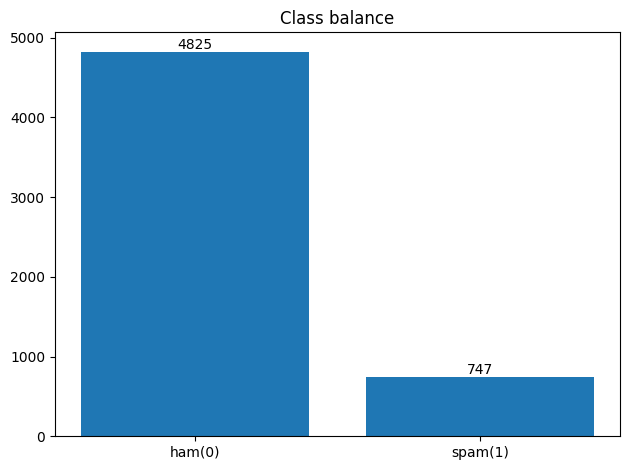

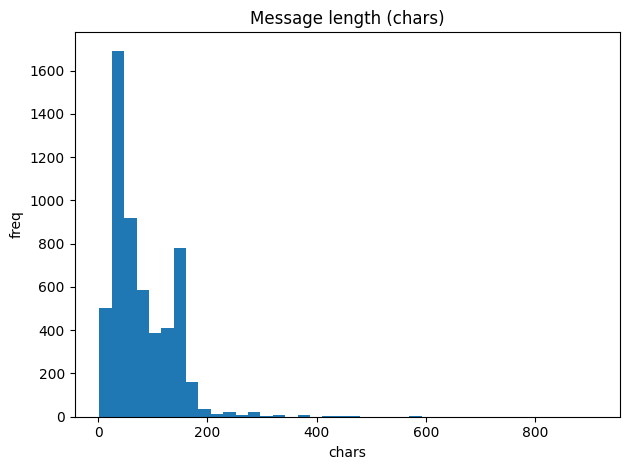

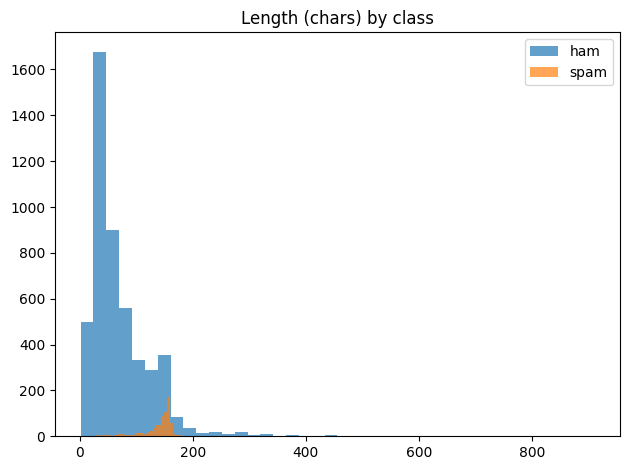

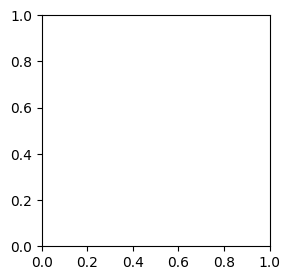

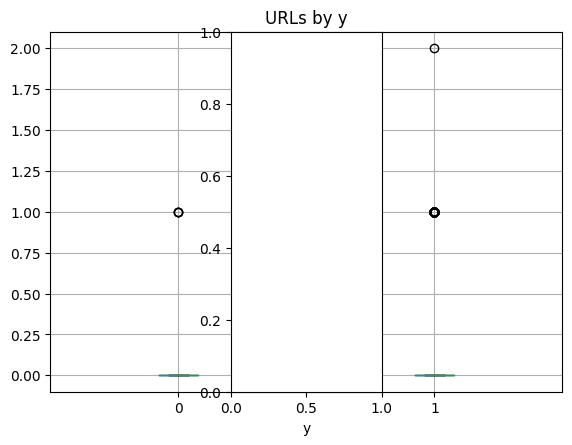

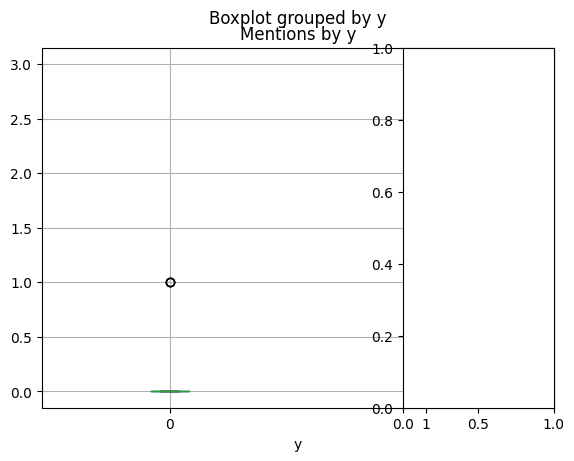

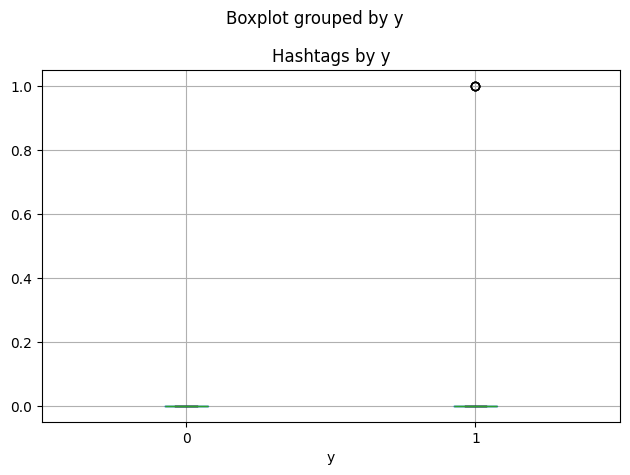

In [ ]:
# ============ CELL 5: EDA plots ============
# Class balance
plt.figure()
counts = df["y"].value_counts().sort_index()
plt.bar(["ham(0)","spam(1)"], counts.values)
plt.title("Class balance")
for i,v in enumerate(counts.values):
    plt.text(i, v, str(v), ha="center", va="bottom")
plt.tight_layout(); plt.show()

# Length distributions
plt.figure()
plt.hist(df["len_char"], bins=40)
plt.title("Message length (chars)")
plt.xlabel("chars"); plt.ylabel("freq")
plt.tight_layout(); plt.show()

# Length by class
plt.figure()
plt.hist(df.loc[df["y"]==0,"len_char"], bins=40, alpha=0.7, label="ham")
plt.hist(df.loc[df["y"]==1,"len_char"], bins=40, alpha=0.7, label="spam")
plt.title("Length (chars) by class")
plt.legend(); plt.tight_layout(); plt.show()

# URL/User/Hashtag counts by class (boxplots)
plt.figure(figsize=(10,3))
plt.subplot(1,3,1); df.boxplot(column="url_cnt", by="y"); plt.title("URLs by y"); plt.suptitle("")
plt.subplot(1,3,2); df.boxplot(column="usr_cnt", by="y"); plt.title("Mentions by y")
plt.subplot(1,3,3); df.boxplot(column="tag_cnt", by="y"); plt.title("Hashtags by y")
plt.tight_layout(); plt.show()


In [ ]:
# ============ CELL 6: Train/test split (stratified) ============
X_train, X_test, y_train, y_test = train_test_split(
    df["clean"], df["y"], test_size=0.2, random_state=42, stratify=df["y"]
)
len(X_train), len(X_test), y_train.mean(), y_test.mean()


(4457, 1115, np.float64(0.13417096701817366), np.float64(0.1336322869955157))

In [ ]:
# ============ CELL 7: TF-IDF features (word 1-2 + char 3-5) ============
word_vec = TfidfVectorizer(ngram_range=(1,2), analyzer="word", min_df=2, lowercase=False)
char_vec = TfidfVectorizer(ngram_range=(3,5), analyzer="char", min_df=2, lowercase=False)

features = FeatureUnion([
    ("word_tfidf", word_vec),
    ("char_tfidf", char_vec),
])
features


FeatureUnion(transformer_list=[('word_tfidf',
                                TfidfVectorizer(lowercase=False, min_df=2,
                                                ngram_range=(1, 2))),
                               ('char_tfidf',
                                TfidfVectorizer(analyzer='char',
                                                lowercase=False, min_df=2,
                                                ngram_range=(3, 5)))])

In [ ]:
# ============ CELL 8: Train baseline LinearSVC (balanced) ============
svm = LinearSVC(class_weight="balanced", random_state=42)
pipeline = Pipeline([("feats", features), ("clf", svm)])

print("Training LinearSVC...")
pipeline.fit(X_train, y_train)
print("Done ✅")


Training LinearSVC...
Done ✅


In [ ]:
# ============ CELL 9: Calibrated copy for PR/ROC curves ============
calibrated = Pipeline([
    ("feats", features),
    ("cal", CalibratedClassifierCV(LinearSVC(class_weight="balanced", random_state=42), method="sigmoid", cv=3))
])
print("Training calibrated copy (for probability-like scores)...")
calibrated.fit(X_train, y_train)
print("Done ✅")


Training calibrated copy (for probability-like scores)...
Done ✅


In [ ]:
# ============ CELL 10: Evaluation metrics ============
y_pred = pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)

scores_raw = pipeline.decision_function(X_test)       # for PR-AUC
scores_cal = calibrated.predict_proba(X_test)[:,1]     # for ROC-AUC

pr_auc  = average_precision_score(y_test, scores_raw)
roc_auc = roc_auc_score(y_test, scores_cal)

print("Accuracy          :", round(acc,4))
print("Precision (macro) :", round(prec_macro,4))
print("Recall    (macro) :", round(rec_macro,4))
print("F1-score (macro)  :", round(f1_macro,4))
print("PR-AUC (spam=1)   :", round(pr_auc,4))
print("ROC-AUC           :", round(roc_auc,4))

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["ham(0)","spam(1)"]))


Accuracy          : 0.9874
Precision (macro) : 0.9729
Recall    (macro) : 0.9729
F1-score (macro)  : 0.9729
PR-AUC (spam=1)   : 0.9598
ROC-AUC           : 0.9924

Classification report:
              precision    recall  f1-score   support

      ham(0)       0.99      0.99      0.99       966
     spam(1)       0.95      0.95      0.95       149

    accuracy                           0.99      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115



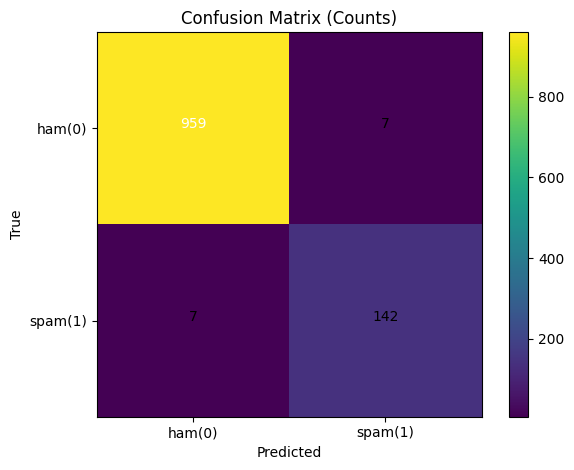

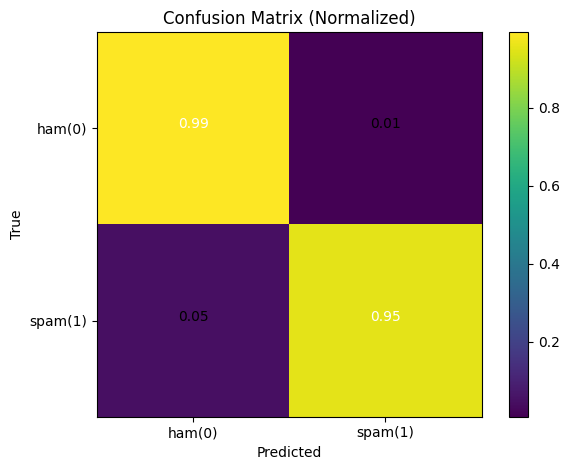

In [ ]:
# ============ CELL 11: Confusion matrices ============
cm = confusion_matrix(y_test, y_pred)

# Raw counts
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Counts)")
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["ham(0)","spam(1)"])
plt.yticks(ticks, ["ham(0)","spam(1)"])
th = cm.max()/2.0
for i in range(2):
    for j in range(2):
        plt.text(j,i,cm[i,j], ha="center", color="white" if cm[i,j] > th else "black")
plt.ylabel("True"); plt.xlabel("Predicted")
plt.tight_layout(); plt.show()

# Normalized
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
plt.figure()
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Confusion Matrix (Normalized)")
plt.colorbar()
plt.xticks(ticks, ["ham(0)","spam(1)"])
plt.yticks(ticks, ["ham(0)","spam(1)"])
thn = cm_norm.max()/2.0
for i in range(2):
    for j in range(2):
        plt.text(j,i,f"{cm_norm[i,j]:.2f}", ha="center", color="white" if cm_norm[i,j] > thn else "black")
plt.ylabel("True"); plt.xlabel("Predicted")
plt.tight_layout(); plt.show()


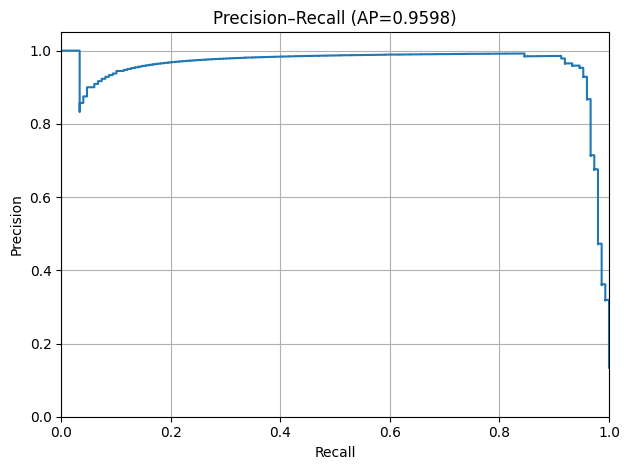

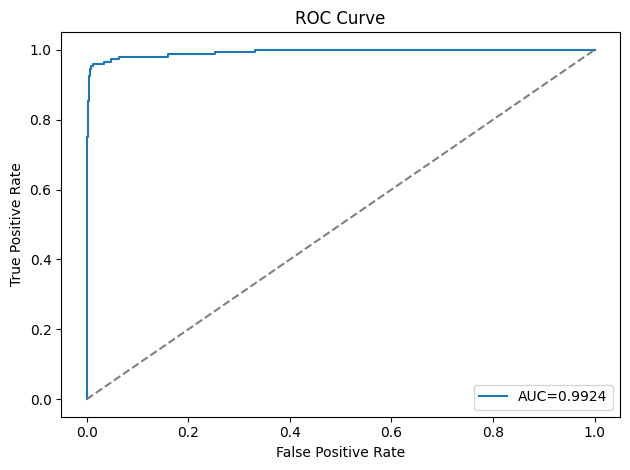

In [ ]:
# ============ CELL 12: PR & ROC curves ============
# PR curve (spam=1)
p, r, _ = precision_recall_curve(y_test, scores_raw)
plt.figure()
plt.step(r, p, where="post")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall (AP={average_precision_score(y_test, scores_raw):.4f})")
plt.ylim([0,1.05]); plt.xlim([0,1])
plt.grid(True); plt.tight_layout(); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, scores_cal)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, scores_cal):.4f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# ============ CELL 13: Top n-grams (spam/ham) ============
def get_feature_names(fu: FeatureUnion):
    names = []
    for name, trans in fu.transformer_list:
        arr = trans.get_feature_names_out()
        names.extend([(name, t) for t in arr])
    return names

def top_features_df(pipeline: Pipeline, top_n:int=20):
    feats = pipeline.named_steps["feats"]
    clf   = pipeline.named_steps["clf"]
    names = get_feature_names(feats)
    coefs = clf.coef_.ravel()
    order_pos = np.argsort(-coefs)[:top_n]
    order_neg = np.argsort(coefs)[:top_n]
    spam_rows = [{"feature": names[i][0]+"::"+names[i][1], "weight": float(coefs[i]), "dir":"spam(+)"}
                 for i in order_pos]
    ham_rows  = [{"feature": names[i][0]+"::"+names[i][1], "weight": float(coefs[i]), "dir":"ham(-)"}
                 for i in order_neg]
    return pd.DataFrame(spam_rows + ham_rows)

tf = top_features_df(pipeline, top_n=25)
tf.head(10)


,feature,weight,dir
0,word_tfidf::num,1.406027,spam(+)
1,word_tfidf::call num,0.894175,spam(+)
2,word_tfidf::txt,0.825384,spam(+)
3,word_tfidf::free,0.770328,spam(+)
4,word_tfidf::text,0.745408,spam(+)
5,word_tfidf::uk,0.742802,spam(+)
6,word_tfidf::your,0.715553,spam(+)
7,word_tfidf::from num,0.713016,spam(+)
8,word_tfidf::sms,0.671964,spam(+)
9,char_tfidf::<num,0.664557,spam(+)


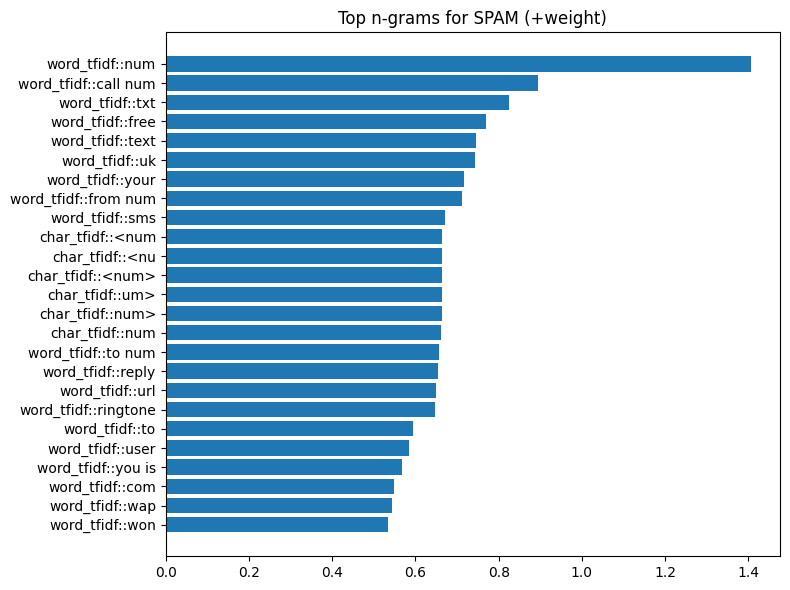

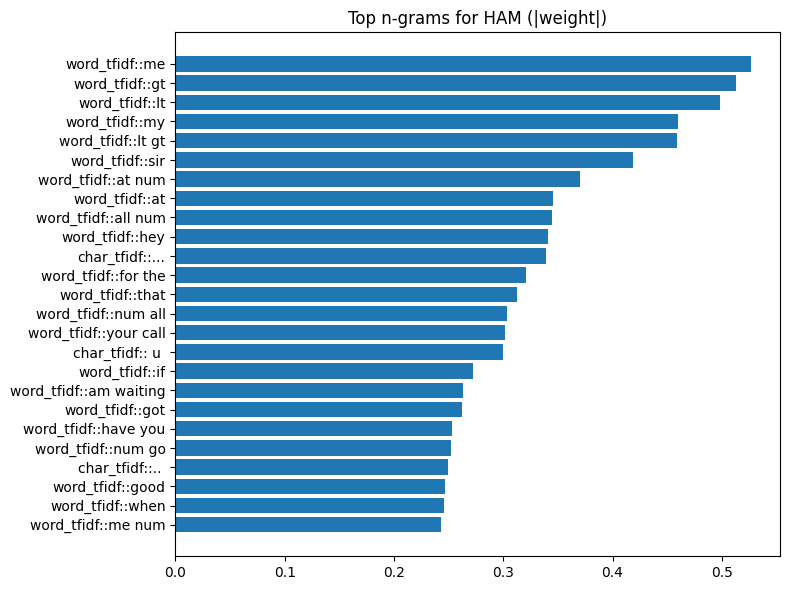

In [ ]:
# ============ CELL 14: Plot top n-grams ============
# Spam
spam_tf = tf[tf["dir"]=="spam(+)"].copy()
plt.figure(figsize=(8,6))
plt.barh(spam_tf["feature"].iloc[::-1], spam_tf["weight"].iloc[::-1])
plt.title("Top n-grams for SPAM (+weight)")
plt.tight_layout(); plt.show()

# Ham
ham_tf = tf[tf["dir"]=="ham(-)"].copy()
plt.figure(figsize=(8,6))
plt.barh(ham_tf["feature"].iloc[::-1], np.abs(ham_tf["weight"].iloc[::-1]))
plt.title("Top n-grams for HAM (|weight|)")
plt.tight_layout(); plt.show()


In [ ]:
# ============ CELL 15: Hardest misclassifications ============
eval_df = pd.DataFrame({"text": X_test.values, "true": y_test.values, "pred": y_pred, "score": scores_raw})
wrong = eval_df[eval_df["true"] != eval_df["pred"]].copy()
if wrong.empty:
    print("🎉 Perfect on this split — no misclassifications!")
else:
    wrong["conf"] = wrong["score"].abs()
    hardest = wrong.sort_values("conf", ascending=False).head(12)
    with pd.option_context("display.max_colwidth", 200):
        display(hardest[["true","pred","score","text"]])


,true,pred,score,text
363,0,1,1.878890,<num>
852,1,0,-1.053259,"do you realize that in about <num> years, we'll have thousands of old ladies running around with tattoos?"
478,1,0,-0.997151,for sale - arsenal dartboard. good condition but no doubles or trebles!
235,1,0,-0.876013,"latest news! police station toilet stolen, cops have nothing to go on!"
1069,1,0,-0.726756,"hi ya babe x u <num>goten bout me?' scammers getting smart..though this is a regular vodafone no, if you respond you get further prem rate msg/subscription. other nos used also. beware!"
796,0,1,0.725244,u <num>.
219,1,0,-0.689974,sorry i missed your call let's talk when you have the time. i'm on <num>
841,1,0,-0.476728,romcapspam everyone around should be responding well to your presence since you are so warm and outgoing. you are bringing in a real breath of sunshine.
301,0,1,0.467106,this is ur face test ( <num> <num> <num> <num> <num> <num> <num> <num> <num> &lt;#&gt; ) select any number i will tell ur face astrology.... am waiting. quick reply...
374,0,1,0.409750,from <num> to <num> only my work timing.


In [ ]:
# ============ CELL 16: Threshold selection demo ============
proba = scores_cal  # calibrated probability-like for spam
grid = np.linspace(0,1,21)
rows = []
for th in grid:
    pred_bin = (proba >= th).astype(int)
    p,r,f1,_ = precision_recall_fscore_support(y_test, pred_bin, average="binary", zero_division=0, pos_label=1)
    rows.append({"threshold": round(float(th),2), "precision": float(p), "recall": float(r), "f1": float(f1)})
th_df = pd.DataFrame(rows)
th_df


,threshold,precision,recall,f1
0,0.00,0.133632,1.000000,0.235759
1,0.05,0.795580,0.966443,0.872727
2,0.10,0.866667,0.959732,0.910828
3,0.15,0.882716,0.959732,0.919614
4,0.20,0.899371,0.959732,0.928571
5,0.25,0.910828,0.959732,0.934641
6,0.30,0.916667,0.959732,0.937705
7,0.35,0.922581,0.959732,0.940789
8,0.40,0.922078,0.953020,0.937294
9,0.45,0.928105,0.953020,0.940397


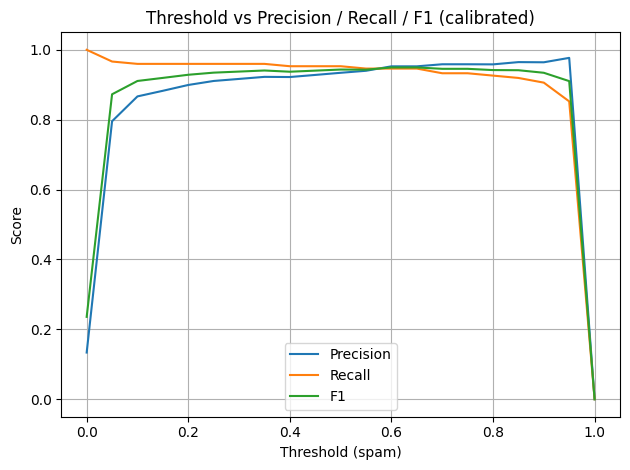

In [ ]:
# ============ CELL 17: Plot threshold vs metrics ============
plt.figure()
plt.plot(th_df["threshold"], th_df["precision"], label="Precision")
plt.plot(th_df["threshold"], th_df["recall"], label="Recall")
plt.plot(th_df["threshold"], th_df["f1"], label="F1")
plt.xlabel("Threshold (spam)"); plt.ylabel("Score")
plt.title("Threshold vs Precision / Recall / F1 (calibrated)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
# ============ CELL 18: Save artifacts ============
os.makedirs("/content/models", exist_ok=True)
MODEL_PATH = "/content/models/spam_svm_tfidf.joblib"
METRICS_PATH = "/content/models/metrics.json"

dump(pipeline, MODEL_PATH)
with open(METRICS_PATH, "w", encoding="utf-8") as f:
    json.dump({
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "precision_macro": float(precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)[0]),
        "recall_macro": float(precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)[1]),
        "f1_macro": float(precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)[2]),
        "pr_auc": float(average_precision_score(y_test, scores_raw)),
        "roc_auc": float(roc_auc_score(y_test, scores_cal)),
        "n_train": int(len(X_train)),
        "n_test": int(len(X_test))
    }, f, indent=2)

print("💾 Saved model to:", MODEL_PATH)
print("💾 Saved metrics to:", METRICS_PATH)


💾 Saved model to: /content/models/spam_svm_tfidf.joblib
💾 Saved metrics to: /content/models/metrics.json


In [ ]:
# ============ CELL 19: GloVe-LSTM (TensorFlow/Keras) ============
# Uses pretrained GloVe word vectors + BiLSTM classifier
# Requirements: tensorflow installed; GloVe file available at GLOVE_PATH

import os, gc, numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score
from sklearn.utils.class_weight import compute_class_weight

# Keras / TF
try:
    import tensorflow as tf
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
except Exception as e:
    raise ImportError("TensorFlow/Keras is required for the GloVe-LSTM cell. Please install tensorflow.") from e

# Prepare tokenization (fit ONLY on training text)
MAX_VOCAB = 30000
MAX_LEN   = 120
tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<oov>")
tok.fit_on_texts(list(X_train))

Xtr_seq = tok.texts_to_sequences(list(X_train))
Xte_seq = tok.texts_to_sequences(list(X_test))

Xtr_pad = pad_sequences(Xtr_seq, maxlen=MAX_LEN, padding="post", truncating="post")
Xte_pad = pad_sequences(Xte_seq, maxlen=MAX_LEN, padding="post", truncating="post")

# Load GloVe embeddings (update this path if needed)
# Example: /content/glove.6B.100d.txt  or /kaggle/input/glove6b/glove.6B.100d.txt
GLOVE_PATH = "/content/glove.6B.100d.txt"
EMB_DIM = 100

emb_index = {}
if os.path.exists(GLOVE_PATH):
    with open(GLOVE_PATH, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            word = parts[0]
            vec  = np.asarray(parts[1:], dtype="float32")
            emb_index[word] = vec
    print(f"Loaded {len(emb_index):,} GloVe vectors from {GLOVE_PATH}")
else:
    print(f"⚠️ GloVe file not found at {GLOVE_PATH}. The embedding layer will be randomly initialized.")

# Build embedding matrix
word_index = tok.word_index
num_words = min(MAX_VOCAB, len(word_index) + 1)
emb_matrix = np.random.normal(scale=0.6, size=(num_words, EMB_DIM)).astype("float32")
if emb_index:
    found = 0
    for w, i in word_index.items():
        if i >= num_words:
            continue
        vec = emb_index.get(w)
        if vec is not None and vec.shape[0] == EMB_DIM:
            emb_matrix[i] = vec
            found += 1
    print(f"Initialized {found:,} / {num_words:,} embedding rows from GloVe.")

# Build model
tf.keras.backend.clear_session()
model_glove = Sequential([
    Embedding(input_dim=num_words, output_dim=EMB_DIM, weights=[emb_matrix] if len(emb_index)>0 else None,
              input_length=MAX_LEN, trainable=False if len(emb_index)>0 else True),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])
model_glove.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
                    loss="binary_crossentropy", metrics=["accuracy"])
model_glove.summary()

# Class weights to counter imbalance
cw = compute_class_weight("balanced", classes=np.array([0,1]), y=y_train.values)
class_weight = {0: float(cw[0]), 1: float(cw[1])}

# Train
hist_glove = model_glove.fit(
    Xtr_pad, y_train.values,
    validation_split=0.1,
    epochs=4,
    batch_size=128,
    verbose=1,
    class_weight=class_weight
)

# Evaluate
proba_glove = model_glove.predict(Xte_pad, batch_size=256).ravel()
pred_glove  = (proba_glove >= 0.5).astype(int)

acc  = accuracy_score(y_test, pred_glove)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred_glove, average="binary", zero_division=0, pos_label=1)
pr_auc  = average_precision_score(y_test, proba_glove)
try:
    roc_auc = roc_auc_score(y_test, proba_glove)
except Exception:
    roc_auc = float("nan")

print("\n[GloVe-LSTM] Metrics:")
print("Accuracy:", round(acc,4), " Precision:", round(prec,4), " Recall:", round(rec,4), " F1:", round(f1,4))
print("PR-AUC:", round(pr_auc,4), " ROC-AUC:", round(roc_auc,4))

# Save
GLOVE_MODEL_PATH = "/content/models/glove_lstm.h5"
model_glove.save(GLOVE_MODEL_PATH)
print("💾 Saved GloVe-LSTM model to:", GLOVE_MODEL_PATH)

gc.collect()


⚠️ GloVe file not found at /content/glove.6B.100d.txt. The embedding layer will be randomly initialized.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 651ms/step - accuracy: 0.6838 - loss: 0.4969 - val_accuracy: 0.9776 - val_loss: 0.0721
Epoch 2/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 370ms/step - accuracy: 0.9847 - loss: 0.0828 - val_accuracy: 0.9865 - val_loss: 0.0434
Epoch 3/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 384ms/step - accuracy: 0.9950 - loss: 0.0298 - val_accuracy: 0.9888 - val_loss: 0.0460
Epoch 4/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 518ms/step - accuracy: 0.9985 - loss: 0.0057 - val_accuracy: 0.9888 - val_loss: 0.0530
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step



[GloVe-LSTM] Metrics:
Accuracy: 0.9865  Precision: 0.9786  Recall: 0.9195  F1: 0.9481
PR-AUC: 0.9811  ROC-AUC: 0.9954
💾 Saved GloVe-LSTM model to: /content/models/glove_lstm.h5


2876

In [ ]:
# ============ CELL 20 (fast): BERT-LSTM with frozen Tiny BERT (PyTorch) ============
import os, numpy as np, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel # Import AutoTokenizer and AutoModel here
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, average_precision_score, roc_auc_score

MODEL_NAME = "prajjwal1/bert-tiny"   # tiny & fast; you can try "distilbert-base-uncased" too
MAX_LEN    = 48
BATCH      = 128                      # drop to 64/32 if OOM
EPOCHS     = 1
LR         = 7e-4
HIDDEN_LSTM = 64

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME)

class SMSDataset(Dataset):
    def __init__(self, texts, labels=None):
        enc = tok(list(texts), padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
        self.enc = enc
        self.labels = None if labels is None else torch.tensor(labels.values, dtype=torch.float32)
    def __len__(self): return self.enc["input_ids"].shape[0]
    def __getitem__(self, i):
        item = {k: v[i] for k, v in self.enc.items()}
        if self.labels is not None: item["labels"] = self.labels[i]
        return item

ds_tr = SMSDataset(X_train, y_train)
ds_te = SMSDataset(X_test,  y_test)
dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True,  pin_memory=True, num_workers=1)
dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, pin_memory=True, num_workers=1)

# ---- Model: frozen encoder + small BiLSTM head ----
class BertLSTMHead(nn.Module):
    def __init__(self, encoder, lstm_hidden=HIDDEN_LSTM):
        super().__init__()
        self.encoder = encoder
        for p in self.encoder.parameters():
            p.requires_grad = False  # freeze
        d_model = self.encoder.config.hidden_size
        self.lstm = nn.LSTM(input_size=d_model, hidden_size=lstm_hidden,
                            batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(lstm_hidden*2, 64)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            seq = self.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state  # [B,T,H]
        lstm_out, _ = self.lstm(seq)           # [B,T,2*H_lstm]
        feat = lstm_out[:, -1, :]              # last timestep
        feat = self.dropout(torch.relu(self.fc1(feat)))
        logits = self.fc2(feat).squeeze(-1)    # [B]
        return logits

encoder = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
model = BertLSTMHead(encoder).to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]  # head only
optim = torch.optim.AdamW(params, lr=LR)
lossf = nn.BCEWithLogitsLoss()

amp = (DEVICE == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=amp)
torch.set_float32_matmul_precision("high")

# ---- Train  ----
model.train()
for epoch in range(EPOCHS):
    tot = 0.0
    for batch in dl_tr:
        input_ids = batch["input_ids"].to(DEVICE, non_blocking=True)
        attention = batch["attention_mask"].to(DEVICE, non_blocking=True)
        labels    = batch["labels"].to(DEVICE, non_blocking=True)
        optim.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=amp):
            logits = model(input_ids, attention)
            loss = lossf(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        tot += loss.item()
    print(f"epoch {epoch+1}: train_loss={tot/len(dl_tr):.4f}")

# ---- Evaluate ----
model.eval()
probs = []
with torch.no_grad():
    for batch in dl_te:
        input_ids = batch["input_ids"].to(DEVICE, non_blocking=True)
        attention = batch["attention_mask"].to(DEVICE, non_blocking=True)
        logits = model(input_ids, attention)
        probs.append(torch.sigmoid(logits).cpu().numpy())
proba_bert_lstm = np.concatenate(probs)
pred_bert_lstm  = (proba_bert_lstm >= 0.5).astype(int)

acc  = accuracy_score(y_test, pred_bert_lstm)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred_bert_lstm, average="binary", zero_division=0, pos_label=1)
pr_auc = average_precision_score(y_test, proba_bert_lstm)
roc_auc = roc_auc_score(y_test, proba_bert_lstm)
print("\n[BERT-LSTM (tiny, frozen)] Metrics:",
      "Acc", round(acc,4), "Prec", round(prec,4), "Rec", round(rec,4), "F1", round(f1,4),
      "PR-AUC", round(pr_auc,4), "ROC-AUC", round(roc_auc,4))

# ---- Save head + tokenizer ----
SAVE_DIR = "/content/models/bert_lstm_tiny_frozen"
os.makedirs(SAVE_DIR, exist_ok=True)
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "bert_lstm_head.pt"))
tok.save_pretrained(SAVE_DIR)
with open(os.path.join(SAVE_DIR, "encoder_name.txt"), "w") as f:
    f.write(MODEL_NAME)
print("💾 Saved BERT-LSTM (tiny, frozen) head + tokenizer to:", SAVE_DIR)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

/tmp/ipython-input-1661440413.py:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-1661440413.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):


model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

epoch 1: train_loss=0.3723

[BERT-LSTM (tiny, frozen)] Metrics: Acc 0.9543 Prec 0.8603 Rec 0.7852 F1 0.8211 PR-AUC 0.8964 ROC-AUC 0.9706
💾 Saved BERT-LSTM (tiny, frozen) head + tokenizer to: /content/models/bert_lstm_tiny_frozen


In [ ]:
# ============ CELL 21 (fast): BERT-BERT (frozen encoder, PyTorch) ============
# pip install -q transformers torch
import os, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, average_precision_score, roc_auc_score

# ---- Speed knobs ----
MODEL_NAME = "distilbert-base-uncased"      # even faster: "prajjwal1/bert-tiny"
MAX_LEN    = 64                              # SMS is short
BATCH_SIZE = 64                              # drop to 32 if OOM
EPOCHS     = 1                               # 1 epoch linear probe
HEAD_LR    = 5e-4                            # higher LR since only head is trained

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME)

class SMSDataset(Dataset):
    def __init__(self, texts, labels=None):
        enc = tok(list(texts), padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
        self.enc = enc
        self.labels = None if labels is None else torch.tensor(labels.values, dtype=torch.long)
    def __len__(self): return self.enc["input_ids"].shape[0]
    def __getitem__(self, i):
        item = {k: v[i] for k,v in self.enc.items()}
        if self.labels is not None: item["labels"] = self.labels[i]
        return item

ds_tr = SMSDataset(X_train, y_train)
ds_te = SMSDataset(X_test,  y_test)
dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True, num_workers=1)
dl_te = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=1)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)

# ---- Freeze encoder; train only classifier head ----
for p in model.base_model.parameters():
    p.requires_grad = False

# Optimizer on head params only
head_params = [p for p in model.parameters() if p.requires_grad]
optim = torch.optim.AdamW(head_params, lr=HEAD_LR)

amp = (DEVICE == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=amp)
torch.set_float32_matmul_precision("high")

# ---- Train (fast) ----
model.train()
for epoch in range(EPOCHS):
    tot = 0.0
    for batch in dl_tr:
        batch = {k: v.to(DEVICE, non_blocking=True) for k,v in batch.items()}
        optim.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=amp):
            out = model(**batch)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        tot += loss.item()
    print(f"epoch {epoch+1}: train_loss={tot/len(dl_tr):.4f}")

# ---- Evaluate ----
model.eval()
probs = []
with torch.no_grad():
    for batch in dl_te:
        batch = {k: v.to(DEVICE, non_blocking=True) for k,v in batch.items() if k!="labels"}
        logits = model(**batch).logits
        probs.append(torch.softmax(logits, dim=1)[:,1].cpu().numpy())
proba_bert_cls = np.concatenate(probs)
pred_bert_cls  = (proba_bert_cls >= 0.5).astype(int)

acc  = accuracy_score(y_test, pred_bert_cls)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred_bert_cls, average="binary", zero_division=0, pos_label=1)
pr_auc = average_precision_score(y_test, proba_bert_cls)
roc_auc = roc_auc_score(y_test, proba_bert_cls)
print("\n[BERT-BERT (frozen)] Metrics:",
      "Acc", round(acc,4), "Prec", round(prec,4), "Rec", round(rec,4), "F1", round(f1,4),
      "PR-AUC", round(pr_auc,4), "ROC-AUC", round(roc_auc,4))

# ---- Save lightweight model ----
SAVE_DIR = "/content/models/bert_bert_frozen_cls"
os.makedirs(SAVE_DIR, exist_ok=True)
model.save_pretrained(SAVE_DIR)
tok.save_pretrained(SAVE_DIR)
print("💾 Saved frozen BERT-BERT classifier to:", SAVE_DIR)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-887805145.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-887805145.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):


epoch 1: train_loss=0.1787

[BERT-BERT (frozen)] Metrics: Acc 0.9722 Prec 0.9758 Rec 0.8121 F1 0.8864 PR-AUC 0.9734 ROC-AUC 0.9944
💾 Saved frozen BERT-BERT classifier to: /content/models/bert_bert_frozen_cls


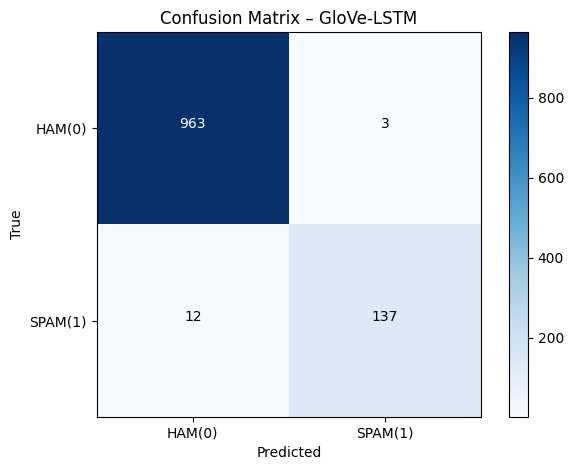

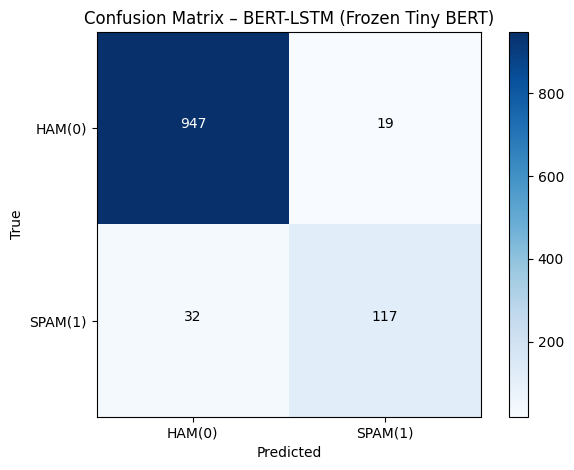

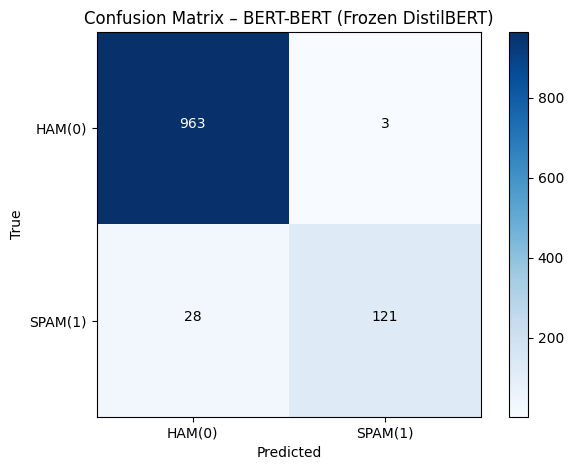

In [ ]:
# ============ COMPARISON: Confusion Matrices for all models ============

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_cm(cm, title):
    plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ["HAM(0)", "SPAM(1)"])
    plt.yticks(ticks, ["HAM(0)", "SPAM(1)"])

    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j],
                     ha="center",
                     color="white" if cm[i,j] > thresh else "black")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


# --- Compute confusion matrices ---
cm_glove     = confusion_matrix(y_test, pred_glove)
cm_bert_lstm = confusion_matrix(y_test, pred_bert_lstm)
cm_bert_cls  = confusion_matrix(y_test, pred_bert_cls)

# --- Plot all three ---
plot_cm(cm_glove,     "Confusion Matrix – GloVe-LSTM")
plot_cm(cm_bert_lstm, "Confusion Matrix – BERT-LSTM (Frozen Tiny BERT)")
plot_cm(cm_bert_cls,  "Confusion Matrix – BERT-BERT (Frozen DistilBERT)")


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute matrices
cm_glove     = confusion_matrix(y_test, pred_glove)
cm_bert_lstm = confusion_matrix(y_test, pred_bert_lstm)
cm_bert_cls  = confusion_matrix(y_test, pred_bert_cls)

# Convert to DataFrames for clean display
df_glove     = pd.DataFrame(cm_glove,     index=["True HAM","True SPAM"], columns=["Pred HAM","Pred SPAM"])
df_bert_lstm = pd.DataFrame(cm_bert_lstm, index=["True HAM","True SPAM"], columns=["Pred HAM","Pred SPAM"])
df_bert_cls  = pd.DataFrame(cm_bert_cls,  index=["True HAM","True SPAM"], columns=["Pred HAM","Pred SPAM"])

print("\n===== GloVe-LSTM Confusion Matrix =====\n")
print(df_glove)

print("\n===== BERT-LSTM (Frozen Tiny BERT) Confusion Matrix =====\n")
print(df_bert_lstm)

print("\n===== BERT-BERT (Frozen DistilBERT) Confusion Matrix =====\n")
print(df_bert_cls)



===== GloVe-LSTM Confusion Matrix =====

           Pred HAM  Pred SPAM
True HAM        963          3
True SPAM        12        137

===== BERT-LSTM (Frozen Tiny BERT) Confusion Matrix =====

           Pred HAM  Pred SPAM
True HAM        947         19
True SPAM        32        117

===== BERT-BERT (Frozen DistilBERT) Confusion Matrix =====

           Pred HAM  Pred SPAM
True HAM        963          3
True SPAM        28        121


In [ ]:
# ============ CELL 19: Predict helpers + interactive loop ============
def predict_sms(msg: str) -> str:
    m = clean_text(msg)
    pred = pipeline.predict([m])[0]
    return "🚩 SPAM" if int(pred)==1 else "📩 HAM"

def batch_predict(msgs):
    mclean = [clean_text(m) for m in msgs]
    preds = pipeline.predict(mclean)
    return pd.DataFrame({"message": msgs, "pred": ["SPAM" if int(p)==1 else "HAM" for p in preds]})

# Quick smoke test
print(batch_predict([
    "XXXMobileMovieClub: To use your credit, click here http://wap.example.com",
    "i will not come to clg today!"
]).to_string(index=False))

# Interactive classify
print("\nType a message to classify (blank to exit):")
while True:
    try:
        m = input().strip()
    except EOFError:
        break
    if not m:
        break
    print("→", predict_sms(m))


                                                                  message pred
XXXMobileMovieClub: To use your credit, click here http://wap.example.com SPAM
                                            i will not come to clg today!  HAM

Type a message to classify (blank to exit):

